In [1]:
import pandas as pd
import numpy as np

import pandas_datareader.data as pdr
from pandas.plotting import scatter_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import datetime as dt
import yfinance as yf
yf.pdr_override()

from sklearn import cluster, covariance, manifold
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.metrics import mean_squared_error, silhouette_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV

from scipy.cluster.hierarchy import fcluster, dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

from itertools import cycle

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, SVC
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

In [4]:
np.set_printoptions(precision=3)
plt.style.use('ggplot')

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.facecolor'] = 'white'

mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.alpha'] = 0.25

mpl.rcParams['legend.fontsize'] = 14

%matplotlib inline


In [5]:
dataset = pd.read_csv('sp500.csv', index_col=0)
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)


In [6]:
droplist = list(missing_fractions[missing_fractions > 0.3].index)
droplist

['CTVA', 'DOW', 'FOX', 'FOXA']

In [7]:
dataset_cleaned = dataset.drop(droplist, axis=1)

In [8]:
dataset_cleaned.isnull().mean().sort_values(ascending=False)

ABT     0.0
MOS     0.0
NLSN    0.0
NEE     0.0
NWS     0.0
       ... 
DXC     0.0
DD      0.0
DRE     0.0
DUK     0.0
ZTS     0.0
Length: 498, dtype: float64

In [9]:
dataset_cleaned.ffill(inplace=True)

In [10]:
dataset_cleaned

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.980000,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.550000,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998
2018-01-04,58.820000,99.379997,199.250000,156.380005,64.660004,183.220001,12.120000,111.000000,10.83,198.539993,...,151.259995,163.399994,47.119999,29.690001,70.489998,69.360001,82.360001,124.739998,50.849998,72.529999
2018-01-05,58.990002,101.110001,202.320007,157.669998,66.370003,185.339996,11.880000,112.180000,10.87,199.470001,...,152.229996,164.490005,46.790001,29.910000,74.150002,69.230003,82.839996,125.980003,50.869999,73.360001
2018-01-08,58.820000,99.489998,207.800003,158.929993,66.629997,185.039993,12.280000,111.389999,10.87,200.529999,...,151.410004,162.300003,47.139999,30.260000,74.639999,69.480003,82.980003,126.220001,50.619999,74.239998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-07,81.040001,74.330002,164.429993,186.809998,55.410000,276.899994,28.930000,158.270004,15.85,74.830002,...,187.589996,107.019997,64.279999,29.830000,92.629997,75.570000,113.690002,134.500000,43.439999,126.070000
2019-10-08,78.510002,73.529999,159.490005,182.199997,54.130001,270.829987,28.230000,154.330002,15.51,71.800003,...,184.360001,102.570000,63.590000,28.309999,89.269997,73.430000,112.589996,131.220001,42.209999,125.379997
2019-10-09,79.500000,73.300003,159.309998,184.339996,53.430000,274.269989,28.459999,154.410004,15.54,72.250000,...,186.199997,104.419998,63.919998,28.760000,90.480003,74.570000,113.330002,133.419998,42.419998,126.430000


In [11]:
returns = dataset_cleaned.pct_change().mean() * 252

In [12]:
returns.name = 'returns'
returns = pd.DataFrame(returns)

In [13]:
returns['volatility'] = dataset_cleaned.pct_change().std() * np.sqrt(252)
returns

,returns,volatility
ABT,0.195117,0.219085
ABBV,-0.109017,0.327481
ABMD,0.045224,0.472339
ACN,0.126415,0.211900
ATVI,-0.017560,0.378203
...,...,...
XYL,0.103895,0.244487
YUM,0.206191,0.175254
ZBH,0.080404,0.232320
ZION,-0.045616,0.257092


In [14]:
scaler = StandardScaler()
rescaledrv = pd.DataFrame(scaler.fit_transform(returns),
                          columns=['returns', 'volatility'],
                          index=returns.index)
rescaledrv

,returns,volatility
ABT,0.794067,-0.702741
ABBV,-0.927603,0.794867
ABMD,-0.054463,2.796251
ACN,0.405155,-0.802003
ATVI,-0.409875,1.495648
...,...,...
XYL,0.277667,-0.351776
YUM,0.856756,-1.308305
ZBH,0.144690,-0.519879
ZION,-0.568698,-0.177625


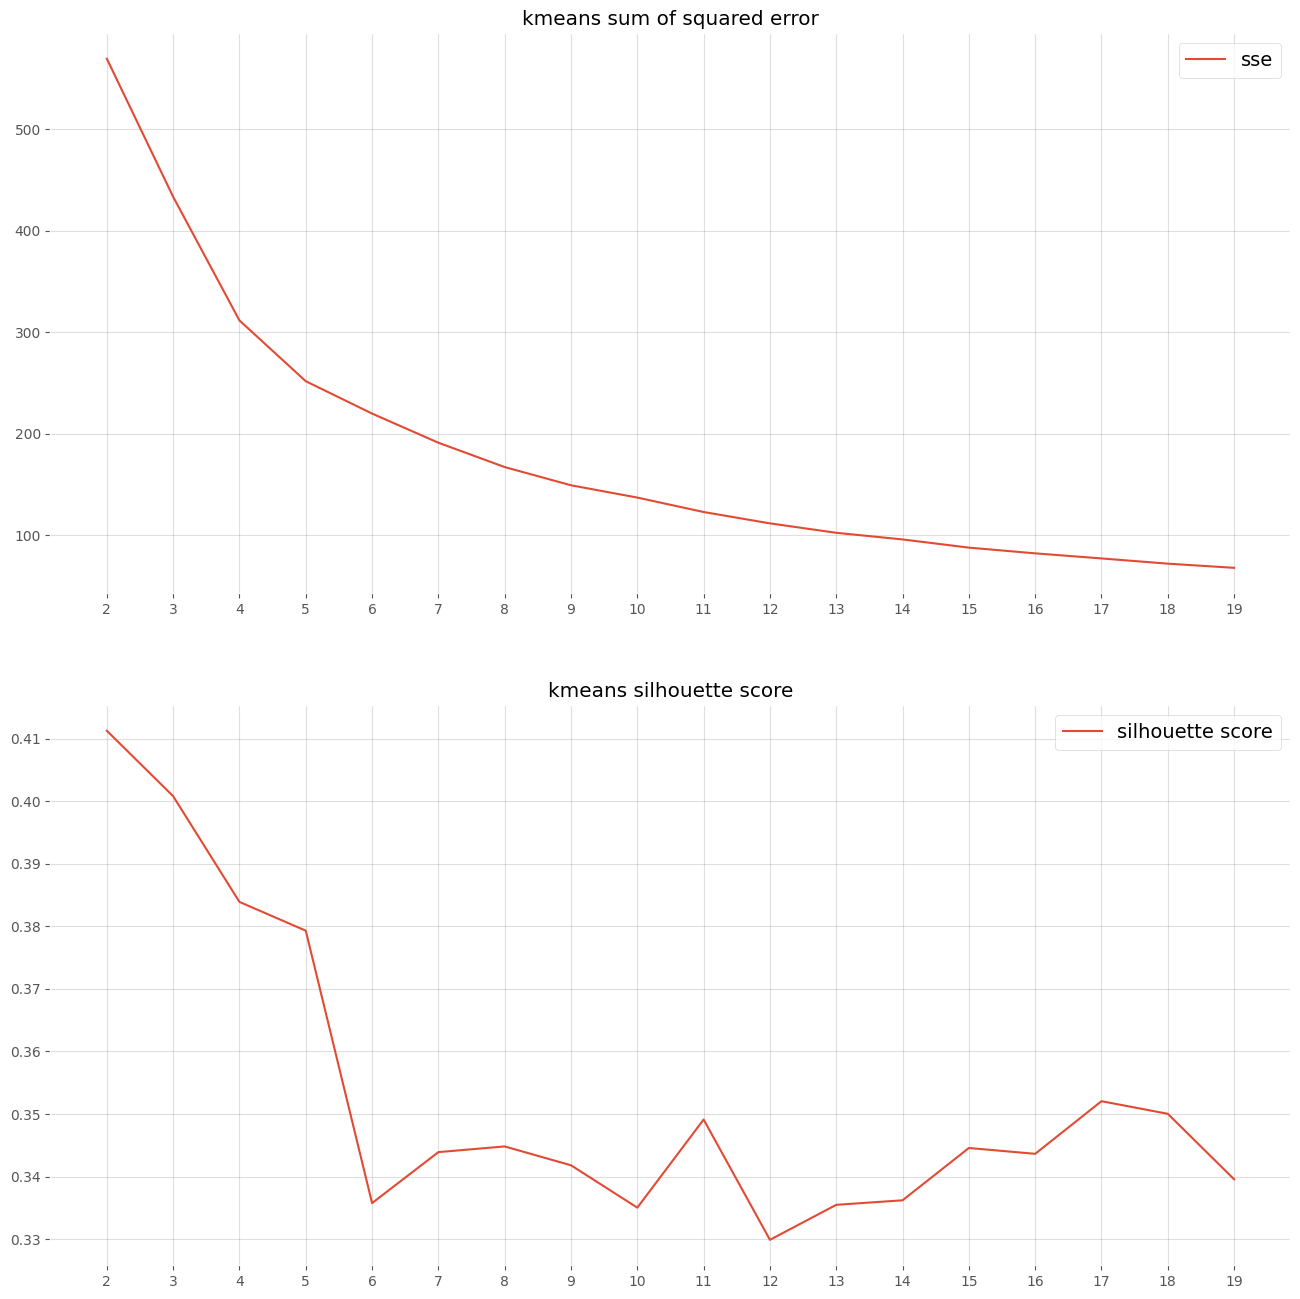

In [15]:
sse = []
silhou_score = []

max_num_clust = 20

for i in range(2, max_num_clust):
    k_means = KMeans(i, n_init=10)
    k_means.fit(rescaledrv)
    sse.append(k_means.inertia_)
    silhou_score.append(silhouette_score(rescaledrv, k_means.labels_))
    
    
fig, ax = plt.subplots(2,1, figsize=(16,16))


ax[0].plot(range(2, max_num_clust), sse, label='sse')

ax[1].plot(range(2, max_num_clust), silhou_score, label='silhouette score')

ax[0].set_title('kmeans sum of squared error')
ax[1].set_title('kmeans silhouette score')

ax[0].set_xticks(range(2, max_num_clust))
ax[1].set_xticks(range(2, max_num_clust))

ax[0].set_xticklabels(range(2, max_num_clust))
ax[1].set_xticklabels(range(2, max_num_clust))

ax[0].legend()
ax[1].legend()

plt.show()

In [16]:
ncluster = 8

In [17]:
kmeans = KMeans(n_clusters=ncluster, n_init=10)
kmeans.fit(rescaledrv)

KMeans(n_init=10)

In [18]:
target_labels = kmeans.predict(rescaledrv)

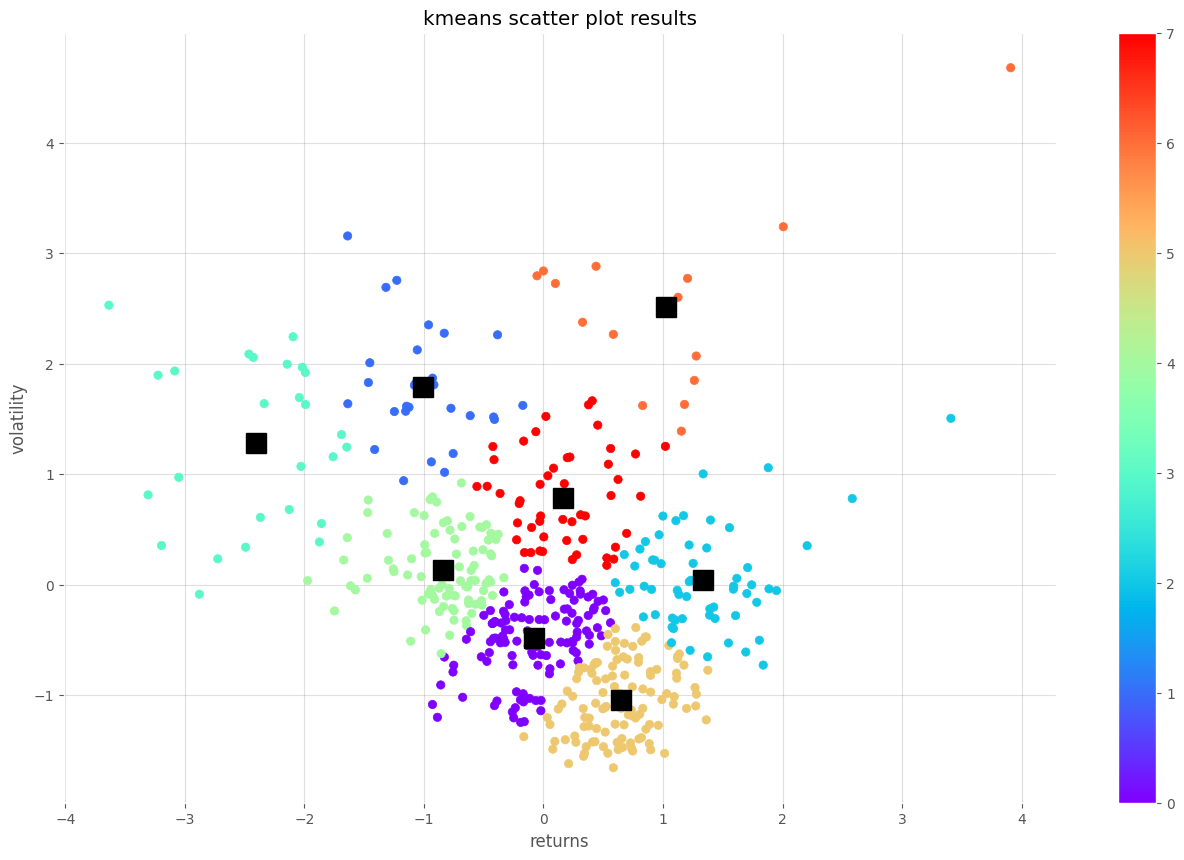

In [19]:
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(16,10))

# fig.suptitle('kmeans scatter plot results')

ax = fig.add_subplot(111)

scatter = ax.scatter(rescaledrv['returns'], 
                     rescaledrv['volatility'], 
                     c=kmeans.labels_,
                     cmap='rainbow')

ax.set_title('kmeans scatter plot results')

plt.colorbar(scatter)

plt.plot(centroids[:,0], centroids[:,1], 'sg', markersize=14, color='black')
plt.xlabel('returns')
plt.ylabel('volatility')

plt.show()

leetcode and brilliant

In [20]:
centroids.shape

(8, 2)

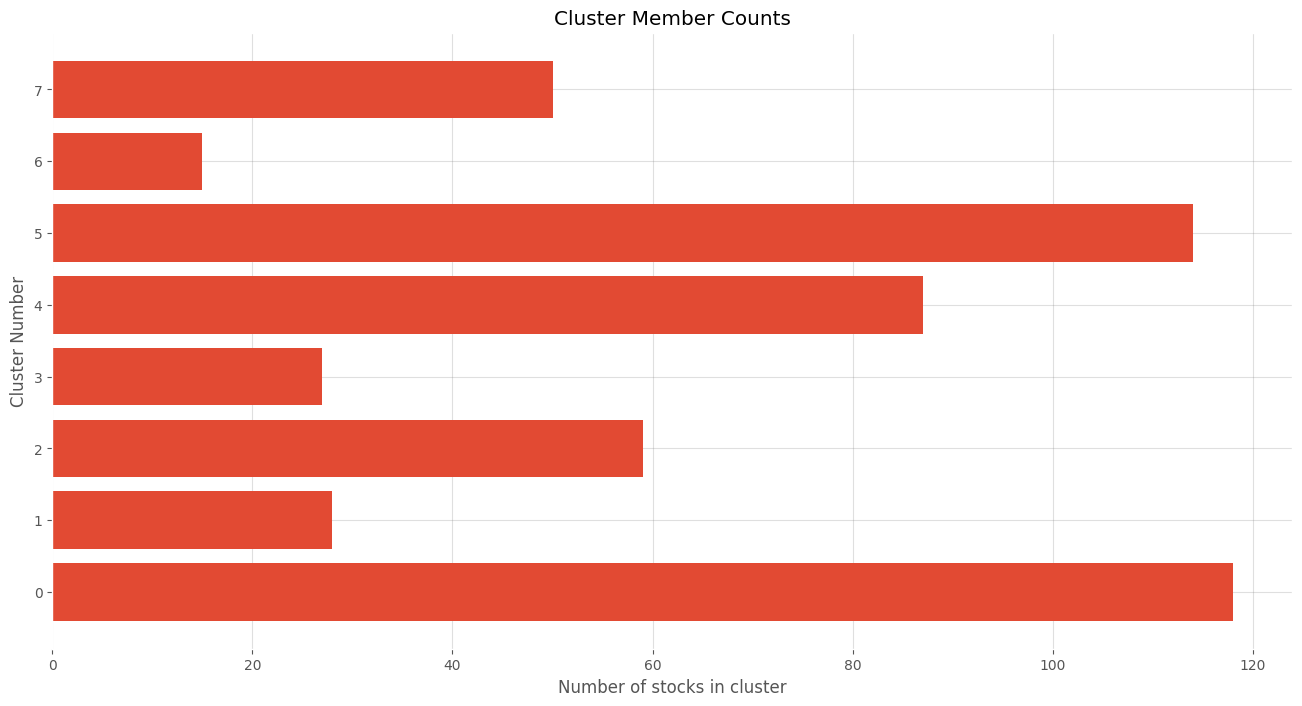

In [21]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_title('Cluster Member Counts')

ax.barh(pd.Series(kmeans.labels_).value_counts().index, pd.Series(kmeans.labels_).value_counts().values)

ax.set_ylabel('Cluster Number')

ax.set_xlabel('Number of stocks in cluster')

plt.show()

In [22]:
Z = linkage(rescaledrv,
            method='ward')

In [23]:
Z

array([[3.300e+01, 3.140e+02, 3.626e-03, 2.000e+00],
       [1.370e+02, 3.460e+02, 6.723e-03, 2.000e+00],
       [8.100e+01, 2.840e+02, 1.075e-02, 2.000e+00],
       ...,
       [9.870e+02, 9.900e+02, 1.603e+01, 2.330e+02],
       [9.890e+02, 9.920e+02, 1.846e+01, 2.890e+02],
       [9.910e+02, 9.930e+02, 2.622e+01, 4.980e+02]])

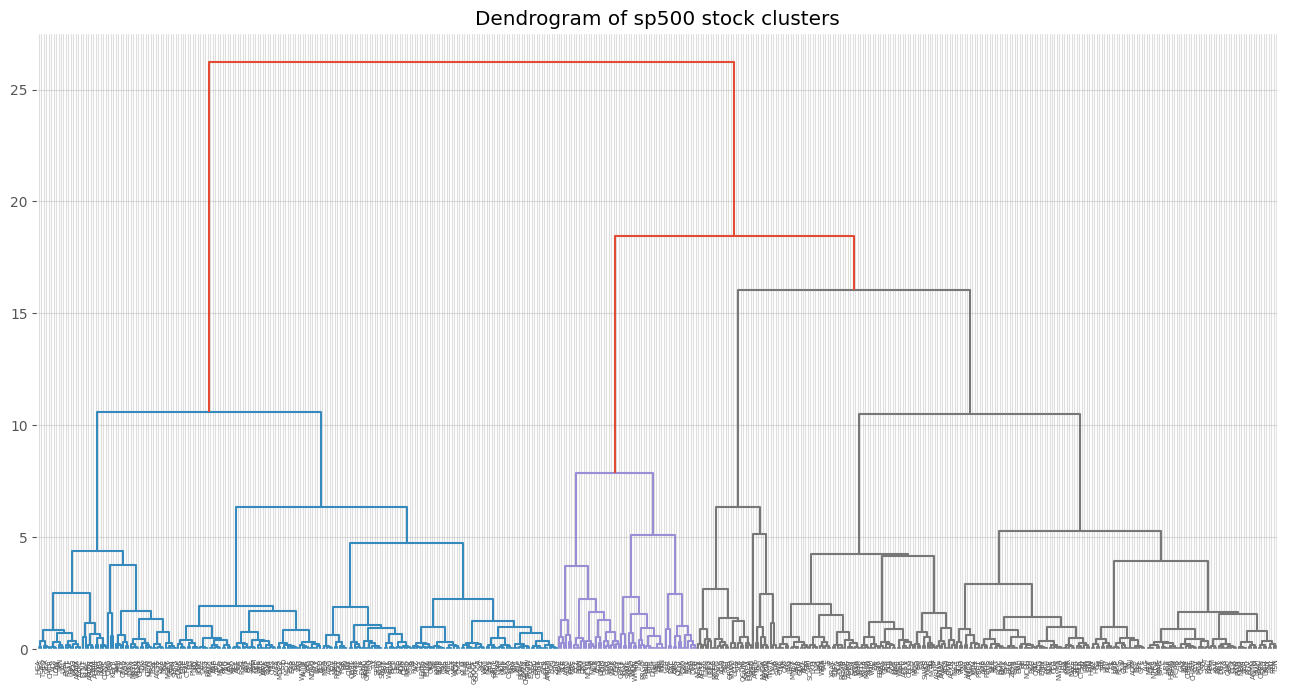

In [24]:
fig = plt.figure(figsize=(16,8))

dendrogram(Z, labels=rescaledrv.index)

plt.title('Dendrogram of sp500 stock clusters')

plt.show()

In [25]:
dist_thres = 13

clusters = fcluster(Z, dist_thres, criterion='distance')

chosen_clusters = pd.DataFrame(clusters, columns=['cluster'])

chosen_clusters['cluster'].unique()

array([1, 4, 3, 2])

In [26]:
nclust = 4

hc = AgglomerativeClustering(n_clusters=nclust,
                             metric='euclidean',
                             linkage='ward')

clust_labels = hc.fit_predict(rescaledrv)

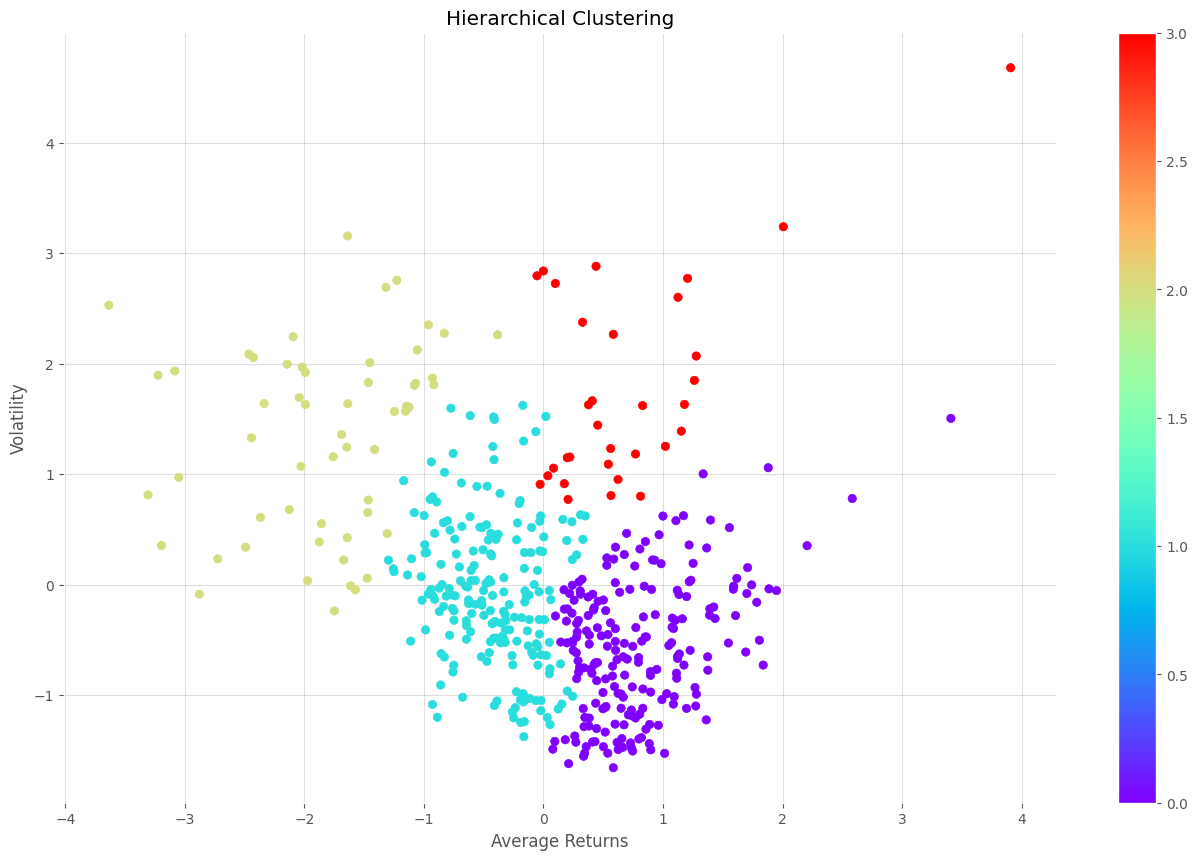

In [27]:
fig, ax = plt.subplots(1,1, figsize=(16,10))

ax.set_title('Hierarchical Clustering')

scatter = ax.scatter(rescaledrv['returns'], rescaledrv['volatility'],c=clust_labels, cmap='rainbow')

ax.set_xlabel('Average Returns')
ax.set_ylabel('Volatility')

plt.colorbar(scatter)

plt.show()

In [28]:
ap = AffinityPropagation()

clust_label2 = ap.fit_predict(rescaledrv)

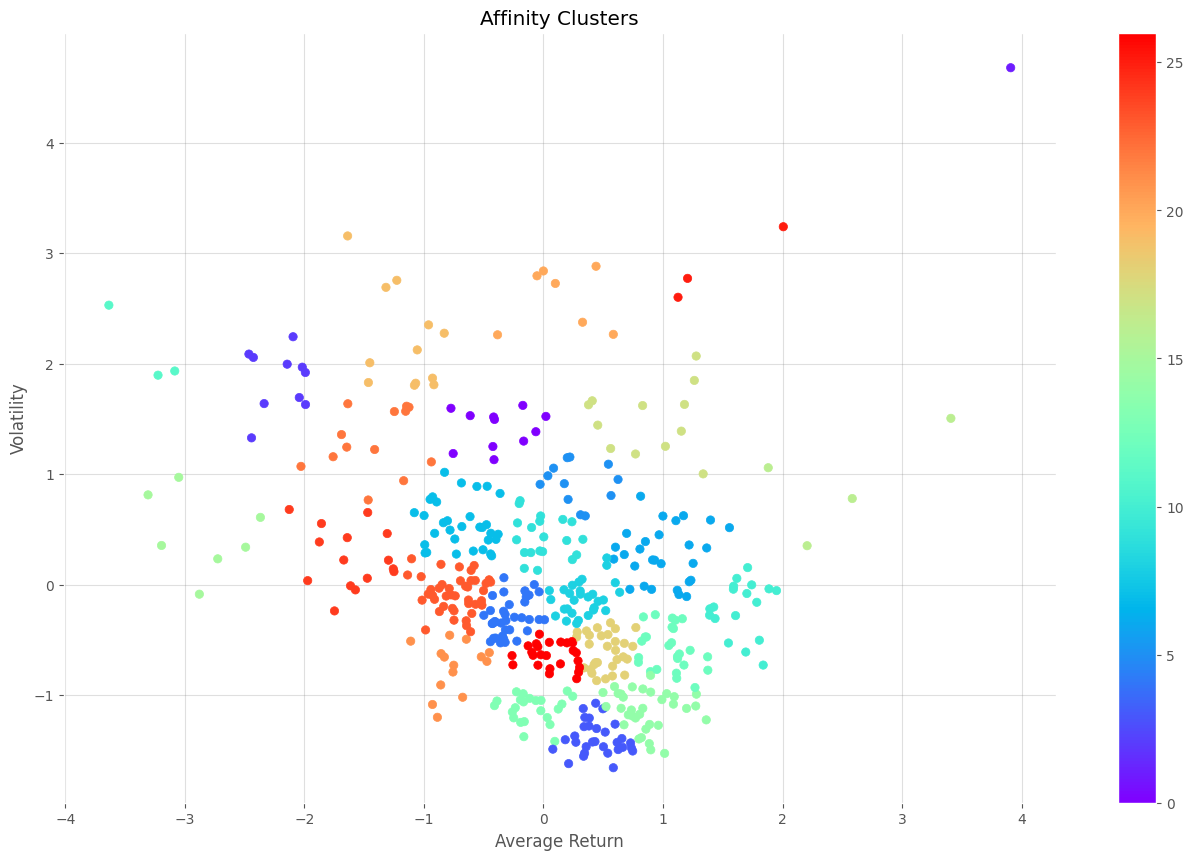

In [29]:
fig, ax = plt.subplots(1,1, figsize=(16,10))

ax.set_title('Affinity Clusters')

scatter = ax.scatter(rescaledrv['returns'], rescaledrv['volatility'], c=clust_label2, cmap='rainbow')

ax.set_xlabel('Average Return')
ax.set_ylabel('Volatility')

plt.colorbar(scatter)

plt.show()

In [30]:
plt.close('all')

plt.figure(1
          )
plt.clf()

<Figure size 640x480 with 0 Axes>

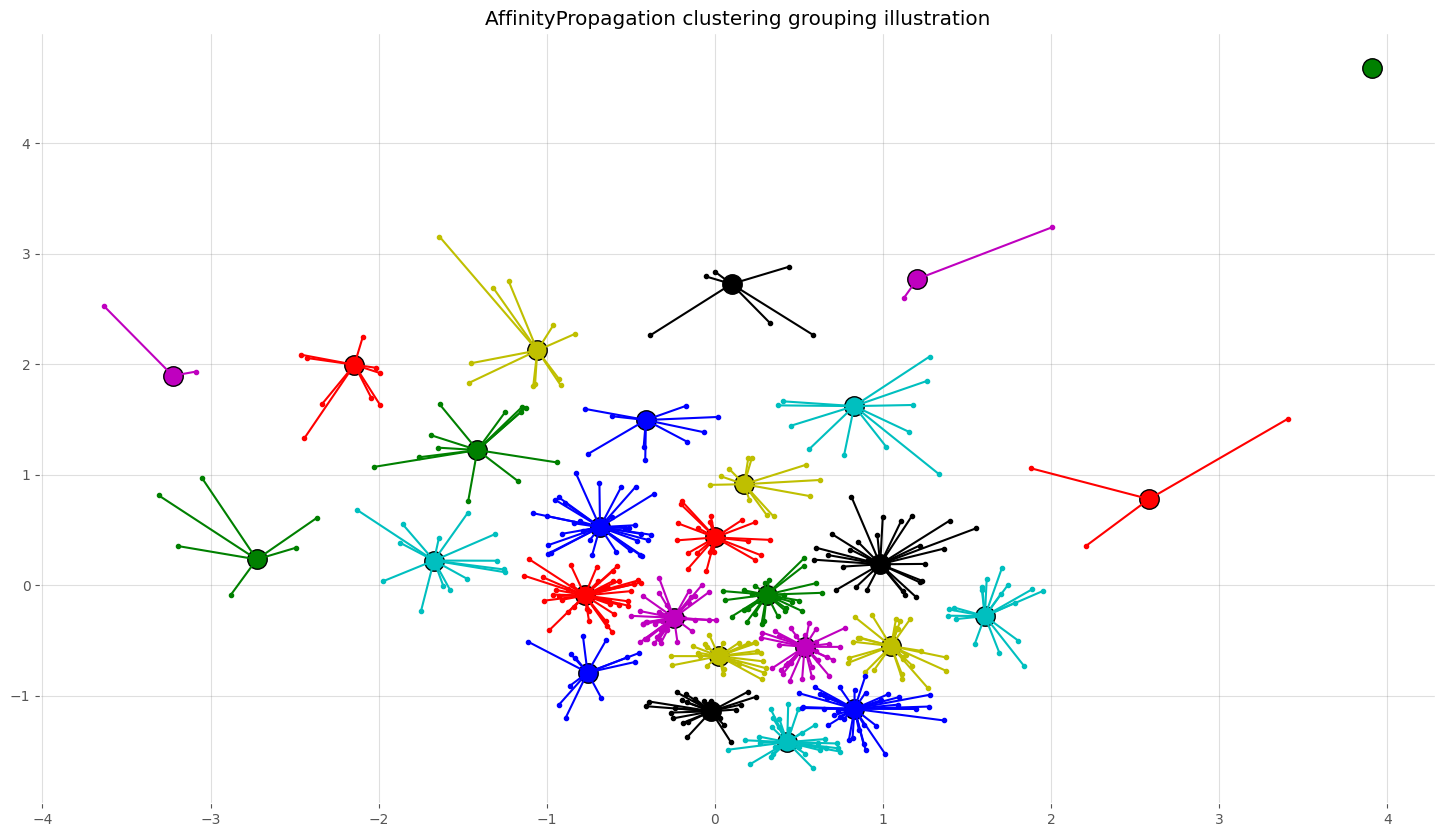

In [31]:
rrv_temp = np.asarray(rescaledrv)
clust_indices = ap.cluster_centers_indices_

ap_labels = ap.labels_

fig = plt.figure(figsize=(18,10))

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

for k, col in zip(range(len(clust_indices)), colors):
    clust_members = ap_labels == k
    clust_center = rrv_temp[clust_indices[k]]
    
    plt.plot(rrv_temp[clust_members,0], rrv_temp[clust_members,1], col + '.')
    
    plt.plot(clust_center[0], clust_center[1], 'o', 
             markersize=14,
             markerfacecolor=col,
             markeredgecolor='black')
    
    for x in rrv_temp[clust_members]:
        plt.plot([x[0], clust_center[0]], [x[1], clust_center[1]], '-', color=col)

plt.title('AffinityPropagation clustering grouping illustration')

plt.show()

In [32]:
# All stock with its cluster label (including -1)
clustered_series = pd.Series(index = rescaledrv.index, data = ap.fit_predict(rescaledrv).flatten()
                            )

# Clustered stock with its cluster label

clustered_series_all = pd.Series(index = rescaledrv.index, data = ap.fit_predict(rescaledrv).flatten()
                                )

clustered_series = clustered_series[clustered_series != -1]

In [33]:
counts = clustered_series.value_counts()
counts

23    42
4     36
14    35
7     32
18    30
3     30
8     29
6     28
12    26
26    25
13    23
9     20
10    18
24    15
21    14
22    13
5     12
17    12
19    12
0     11
2     10
15     7
20     7
16     4
11     3
25     3
1      1
Name: count, dtype: int64

In [34]:
cluster_vis_list = list(counts[(counts < 25) & (counts > 1)].index)[::-1]

In [35]:
CLUSTER_SIZE_LIMIT = 9999

counts = clustered_series.value_counts()

ticker_count_reduced = counts[(counts>1) & (counts <= CLUSTER_SIZE_LIMIT)]

In [36]:
ticker_count_reduced


23    42
4     36
14    35
7     32
18    30
3     30
8     29
6     28
12    26
26    25
13    23
9     20
10    18
24    15
21    14
22    13
5     12
17    12
19    12
0     11
2     10
15     7
20     7
16     4
11     3
25     3
Name: count, dtype: int64

In [37]:
cluster_vis_list

[25, 11, 16, 20, 15, 2, 0, 19, 17, 5, 22, 21, 24, 10, 9, 13]

In [38]:
ticker_count_reduced.index

Index([23,  4, 14,  7, 18,  3,  8,  6, 12, 26, 13,  9, 10, 24, 21, 22,  5, 17,
       19,  0,  2, 15, 20, 16, 11, 25],
      dtype='int64')

In [39]:
clustered_series

ABT     12
ABBV     7
ABMD    20
ACN     18
ATVI     0
        ..
XYL      8
YUM     14
ZBH     26
ZION    23
ZTS     10
Length: 498, dtype: int64

In [40]:
tickers = clustered_series[clustered_series == 25].index
dataset[tickers]

,TWTR,UAA,UA
Date,,,
2018-01-02,24.510000,15.030000,13.970000
2018-01-03,24.450001,15.720000,14.400000
2018-01-04,23.990000,15.920000,14.750000
2018-01-05,24.320000,15.870000,14.730000
2018-01-08,24.590000,15.980000,14.780000
...,...,...,...
2019-10-07,40.799999,19.100000,17.469999
2019-10-08,39.700001,19.010000,17.350000
2019-10-09,39.500000,19.469999,17.750000


In [41]:
from statsmodels.tsa.stattools import coint

In [42]:
def find_coint_pairs(data, clust, signif = 0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n,n))
    pval_matrix = np.zeros((n,n))
    
    s = pd.Series(index=data.columns, data=clust)
    unique_clust = np.unique(s)
    
    pairs = []
    
    for clust in unique_clust:
        if len(s[s==clust]) < 2:
            continue
        clust_data = data[s[s==clust].index]
#         keys = clust_data.keys()
        keys = clust_data.columns
        for i in range(1):
            for j in range(i+1,len(clust_data.columns)):
                S1 = clust_data[keys[i]]
                S2 = clust_data[keys[j]]
                result = coint(S1, S2)
                score = result[0]
                pval = result[1]
                score_matrix[i,j] = score
                pval_matrix[i,j] = pval
                if pval < signif:
                    pairs.append((S1.name, S2.name))
                    
    return score_matrix, pval_matrix, pairs
                

In [43]:
score_mat, pval_mat, pairs = find_coint_pairs(dataset_cleaned, ap.labels_)
pairs

[('AAL', 'FCX'),
 ('AFL', 'ARE'),
 ('AFL', 'ED'),
 ('AFL', 'MMC'),
 ('AFL', 'WM'),
 ('AIG', 'TEL'),
 ('ADBE', 'ADI'),
 ('ADBE', 'CDNS'),
 ('ADBE', 'VFC'),
 ('ABBV', 'BWA'),
 ('A', 'WAT'),
 ('XEC', 'DXC'),
 ('ABT', 'AZO'),
 ('ABT', 'CHD'),
 ('ABT', 'IQV'),
 ('ABT', 'WELL'),
 ('ALL', 'GL'),
 ('CMG', 'EW'),
 ('CMG', 'KEYS'),
 ('ADSK', 'ULTA'),
 ('ADSK', 'XLNX'),
 ('ACN', 'EQIX'),
 ('ALB', 'CTL'),
 ('ALB', 'FANG'),
 ('ALB', 'EOG'),
 ('ALB', 'HP'),
 ('ALB', 'NOV'),
 ('ALB', 'PVH'),
 ('ALB', 'TPR'),
 ('AOS', 'FITB'),
 ('AOS', 'ZION'),
 ('MO', 'CCL')]

In [44]:
sp = pd.read_csv('snp500_daily_prices_volume20-23_reco.csv', index_col='Date', parse_dates=True,
                       date_format='%d/%m/%Y')

In [45]:
sp.dropna(how='any', inplace=True)

In [46]:
in_pair = [x for x in np.unique(sp['tic']) if x in np.unique(pairs)]


In [47]:
unique_pairs = np.unique(pairs)
not_in_pair = [x for x in unique_pairs if x not in in_pair]
not_in_pair

['CTL', 'WELL', 'XLNX']

In [48]:
for i,j in enumerate(pairs):
    if list(j)[0] in not_in_pair or list(j)[1] in not_in_pair:
        p = pairs.pop(i)

In [49]:
pairs = [x for x in pairs if x not in [('XEC', 'DXC'), 
                                       ('ALL', 'GL'), 
                                       ('ALB', 'FANG'), 
                                       ('ALB', 'EOG'),
                                       ('ALB', 'HP'),
                                       ('ALB', 'NOV'),
                                       ('ALB', 'PVH'),
                                       ('ALB', 'TPR'),
                                       ('AOS', 'ZION'),
                                       ('MO', 'CCL')]] #dropping due to missing values
pairs

[('AAL', 'FCX'),
 ('AFL', 'ARE'),
 ('AFL', 'ED'),
 ('AFL', 'MMC'),
 ('AFL', 'WM'),
 ('AIG', 'TEL'),
 ('ADBE', 'ADI'),
 ('ADBE', 'CDNS'),
 ('ADBE', 'VFC'),
 ('ABBV', 'BWA'),
 ('A', 'WAT'),
 ('ABT', 'AZO'),
 ('ABT', 'CHD'),
 ('ABT', 'IQV'),
 ('CMG', 'EW'),
 ('CMG', 'KEYS'),
 ('ADSK', 'ULTA'),
 ('ACN', 'EQIX'),
 ('AOS', 'FITB')]

In [52]:
import numpy as np
import pandas as pd
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, cross


def prep_data(tickers):
    data = pd.read_csv('snp500_daily_prices_volume20-23_reco.csv', index_col='Date', parse_dates=True,
                       date_format='%d/%m/%Y')
    data.dropna(how='any', axis=0, inplace=True)
    data['Open'] = pd.to_numeric(data['Open'])

    if any(data[data['tic'] == tickers[0]].loc[:, 'Close']
           - data[data['tic'] == tickers[1]].loc[:, 'Close'] < 0):
        
        data_sprd = data[data['tic'] == tickers[1]].loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']] - \
                    data[data['tic'] == tickers[0]].loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']]
                                 
    else:
        data_sprd = data[data['tic'] == tickers[0]].loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']] - \
                    data[data['tic'] == tickers[1]].loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']]

    data_sprd['mean_sprd'] = data_sprd['Close'].rolling(506, center=False).mean()
    data_sprd['stdv_sprd'] = data_sprd['Close'].rolling(506, center=False).std()

    data_sprd = data_sprd.iloc[505:, :]
    
    return data_sprd


for i,j in enumerate(pairs):

    class PairsTradingStrategy(Strategy):
        nstdv, stop_loss, size, hold_days = 2.0, 3.0, 0.1, 999 # params[i]
        exit = 0.0

        def init(self):
            super().init()

            self.last_trade_date = self.data.index[0]

            def z_score_func(c):
                return (c - self.data['mean_sprd']) / self.data['stdv_sprd']

            self.zsi = self.I(z_score_func, self.data.Close)

        def next(self):
            super().next()

            if self.stop_loss > self.zsi > self.nstdv:
                self.sell(size=self.size)
            elif -self.stop_loss < self.zsi < -self.nstdv:
                self.buy(size=self.size)
            elif cross(self.zsi, self.exit) or \
                    crossover(self.zsi, self.stop_loss) or \
                    crossover(-self.stop_loss, self.zsi) or \
                    (self.data.index[-1] - self.last_trade_date) >= pd.Timedelta(days=self.hold_days):
                self.position.close()

            if len(self.trades) != 0:
                self.last_trade_date = self.trades[-1].entry_time


    aum = 1000000
    
    dataf = prep_data(j)

    # bt = Backtest(dataf, PairsTradingStrategy, commission=.002,
    #               cash=aum*weights[j], trade_on_close=True)

    bt = Backtest(dataf, PairsTradingStrategy, commission=.002,
                  cash=aum, trade_on_close=True)

    stats = bt.run()
    print(stats)

    opt = bt.optimize(nstdv=list(np.arange(1.0, 3.5, 0.5)),
                      stop_loss=list(np.arange(1.5, 4.5, 0.5)),
                      constraint=lambda x: abs(x.nstdv) < abs(x.stop_loss),
                      size=list(np.arange(0.1, 1.00, 0.1)),
                      hold_days=list(np.arange(30, 65, 5)),
                      maximize='Sharpe Ratio')

    opt_params = opt._strategy
    print(opt_params)
#     print(opt)
    column = str(pairs[i][0]) + "_" + str(pairs[i][1])
    returns_stream = stats._equity_curve
    pnl = pd.DataFrame({column: pd.Series(returns_stream['Equity'].pct_change())}).transpose()
    pnl.to_csv(f"{column}_pnl_is_best.csv")
    stats.to_csv(f"{column}_stats_is_best.csv")
    returns_stream.to_csv(f"{column}_return_stream_best.csv")

    bt.plot(filename=f"{column}_is_best.html")

Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                   25.141243
Equity Final [$]                1539657.68734
Equity Peak [$]                 1539657.68734
Return [%]                          53.965769
Buy & Hold Return [%]              -13.946326
Return (Ann.) [%]                   35.962956
Volatility (Ann.) [%]               34.112392
Sharpe Ratio                         1.054249
Sortino Ratio                        2.839872
Calmar Ratio                         2.070498
Max. Drawdown [%]                  -17.369233
Avg. Drawdown [%]                   -5.349959
Max. Drawdown Duration      330 days 00:00:00
Avg. Drawdown Duration       50 days 00:00:00
# Trades                                   29
Win Rate [%]                            100.0
Best Trade [%]                      62.255592
Worst Trade [%]                     53.577515
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=2.5,stop_loss=3.0,size=0.1,hold_days=60)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                   77.118644
Equity Final [$]                 484836.56124
Equity Peak [$]                  1078400.1954
Return [%]                         -51.516344
Buy & Hold Return [%]              -69.515969
Return (Ann.) [%]                  -40.270823
Volatility (Ann.) [%]                26.61449
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -55.66759
Avg. Drawdown [%]                  -12.549745
Max. Drawdown Duration      306 days 00:00:00
Avg. Drawdown Duration       67 days 00:00:00
# Trades                                   86
Win Rate [%]                         1.162791
Best Trade [%]                      20.433496
Worst Trade [%]                    -50.310039
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=3.0,stop_loss=4.0,size=0.1,hold_days=35)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                    1000000.0
Equity Peak [$]                     1000000.0
Return [%]                                0.0
Buy & Hold Return [%]                8.302308
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=1.5,stop_loss=2.0,size=0.5,hold_days=35)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                    1000000.0
Equity Peak [$]                     1000000.0
Return [%]                                0.0
Buy & Hold Return [%]                0.009178
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=1.5,stop_loss=2.0,size=0.1,hold_days=45)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                   36.723164
Equity Final [$]                1018556.51254
Equity Peak [$]                 1020470.28254
Return [%]                           1.855651
Buy & Hold Return [%]               -6.470757
Return (Ann.) [%]                    1.317468
Volatility (Ann.) [%]                1.657575
Sharpe Ratio                         0.794817
Sortino Ratio                        1.257315
Calmar Ratio                         0.586581
Max. Drawdown [%]                   -2.246012
Avg. Drawdown [%]                    -0.54749
Max. Drawdown Duration      348 days 00:00:00
Avg. Drawdown Duration       65 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      18.570722
Worst Trade [%]                     18.570722
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=1.5,stop_loss=2.5,size=0.30000000000000004,hold_days=45)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                    32.20339
Equity Final [$]                1365618.95308
Equity Peak [$]                 1365618.95308
Return [%]                          36.561895
Buy & Hold Return [%]              -32.776759
Return (Ann.) [%]                   24.834975
Volatility (Ann.) [%]               20.576086
Sharpe Ratio                         1.206982
Sortino Ratio                        2.828837
Calmar Ratio                         2.065315
Max. Drawdown [%]                  -12.024789
Avg. Drawdown [%]                   -2.365975
Max. Drawdown Duration       63 days 00:00:00
Avg. Drawdown Duration       14 days 00:00:00
# Trades                                   15
Win Rate [%]                            100.0
Best Trade [%]                       59.10619
Worst Trade [%]                     38.185168
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=2.0,stop_loss=2.5,size=0.1,hold_days=30)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                   75.141243
Equity Final [$]                1433755.72434
Equity Peak [$]                 1433755.72434
Return [%]                          43.375572
Buy & Hold Return [%]              -37.993905
Return (Ann.) [%]                   29.237664
Volatility (Ann.) [%]               55.650144
Sharpe Ratio                         0.525383
Sortino Ratio                        1.064335
Calmar Ratio                         0.858723
Max. Drawdown [%]                  -34.047835
Avg. Drawdown [%]                   -7.222032
Max. Drawdown Duration      112 days 00:00:00
Avg. Drawdown Duration       25 days 00:00:00
# Trades                                   29
Win Rate [%]                            100.0
Best Trade [%]                      76.267971
Worst Trade [%]                      6.517136
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=2.5,stop_loss=3.0,size=0.1,hold_days=35)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                    77.40113
Equity Final [$]                 832068.53686
Equity Peak [$]                 1101841.46306
Return [%]                         -16.793146
Buy & Hold Return [%]              -50.977152
Return (Ann.) [%]                  -12.266773
Volatility (Ann.) [%]               49.992029
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -53.347035
Avg. Drawdown [%]                   -8.747928
Max. Drawdown Duration      289 days 00:00:00
Avg. Drawdown Duration       44 days 00:00:00
# Trades                                   52
Win Rate [%]                        51.923077
Best Trade [%]                      62.920111
Worst Trade [%]                    -25.705505
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=2.5,stop_loss=3.0,size=0.1,hold_days=40)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                        50.0
Equity Final [$]                 1456125.2599
Equity Peak [$]                  1456125.2599
Return [%]                          45.612526
Buy & Hold Return [%]              -18.360983
Return (Ann.) [%]                   30.669844
Volatility (Ann.) [%]               29.310193
Sharpe Ratio                         1.046388
Sortino Ratio                        2.290754
Calmar Ratio                         2.024461
Max. Drawdown [%]                  -15.149635
Avg. Drawdown [%]                   -4.888847
Max. Drawdown Duration       57 days 00:00:00
Avg. Drawdown Duration       19 days 00:00:00
# Trades                                   15
Win Rate [%]                            100.0
Best Trade [%]                      64.847621
Worst Trade [%]                     48.513251
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=1.5,stop_loss=2.5,size=0.30000000000000004,hold_days=45)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                   84.180791
Equity Final [$]                1113670.19306
Equity Peak [$]                 1113670.19306
Return [%]                          11.367019
Buy & Hold Return [%]                3.756649
Return (Ann.) [%]                     7.96534
Volatility (Ann.) [%]                24.61549
Sharpe Ratio                         0.323591
Sortino Ratio                        0.601743
Calmar Ratio                         0.392771
Max. Drawdown [%]                  -20.279837
Avg. Drawdown [%]                   -6.278725
Max. Drawdown Duration      155 days 00:00:00
Avg. Drawdown Duration       50 days 00:00:00
# Trades                                   44
Win Rate [%]                        59.090909
Best Trade [%]                      21.371374
Worst Trade [%]                    -10.790687
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=1.5,stop_loss=2.0,size=0.1,hold_days=35)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                    3.954802
Equity Final [$]                  981468.1332
Equity Peak [$]                  1003662.3647
Return [%]                          -1.853187
Buy & Hold Return [%]              -34.866177
Return (Ann.) [%]                   -1.322768
Volatility (Ann.) [%]                2.697442
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -2.800472
Avg. Drawdown [%]                   -1.515935
Max. Drawdown Duration       16 days 00:00:00
Avg. Drawdown Duration        9 days 00:00:00
# Trades                                   14
Win Rate [%]                        21.428571
Best Trade [%]                        1.15064
Worst Trade [%]                     -5.330073
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=1.0,stop_loss=1.5,size=0.9,hold_days=50)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                   99.435028
Equity Final [$]                 780156.20042
Equity Peak [$]                 1110733.44042
Return [%]                          -21.98438
Buy & Hold Return [%]               19.871778
Return (Ann.) [%]                  -16.199252
Volatility (Ann.) [%]               27.065212
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -41.334086
Avg. Drawdown [%]                  -10.240287
Max. Drawdown Duration      376 days 00:00:00
Avg. Drawdown Duration       72 days 00:00:00
# Trades                                   22
Win Rate [%]                              0.0
Best Trade [%]                     -14.192698
Worst Trade [%]                    -29.552339
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=2.5,stop_loss=3.0,size=0.1,hold_days=45)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                   14.971751
Equity Final [$]                 967968.45712
Equity Peak [$]                 1273666.05712
Return [%]                          -3.203154
Buy & Hold Return [%]              -74.417359
Return (Ann.) [%]                   -2.290881
Volatility (Ann.) [%]               20.494801
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -26.517971
Avg. Drawdown [%]                   -6.471848
Max. Drawdown Duration       42 days 00:00:00
Avg. Drawdown Duration       13 days 00:00:00
# Trades                                    3
Win Rate [%]                              0.0
Best Trade [%]                      -6.908871
Worst Trade [%]                    -14.125238
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=1.5,stop_loss=2.5,size=0.9,hold_days=30)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                    7.062147
Equity Final [$]                1190449.17786
Equity Peak [$]                 1190449.17786
Return [%]                          19.044918
Buy & Hold Return [%]              -29.455924
Return (Ann.) [%]                   13.212887
Volatility (Ann.) [%]                9.295334
Sharpe Ratio                         1.421454
Sortino Ratio                        3.172485
Calmar Ratio                         4.366138
Max. Drawdown [%]                   -3.026219
Avg. Drawdown [%]                   -2.345811
Max. Drawdown Duration       13 days 00:00:00
Avg. Drawdown Duration        6 days 00:00:00
# Trades                                   14
Win Rate [%]                            100.0
Best Trade [%]                      31.556305
Worst Trade [%]                     18.358829
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=2.5,stop_loss=3.0,size=0.1,hold_days=30)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                    6.779661
Equity Final [$]                 983094.30816
Equity Peak [$]                 1002559.50838
Return [%]                          -1.690569
Buy & Hold Return [%]               27.518514
Return (Ann.) [%]                   -1.206409
Volatility (Ann.) [%]                2.576286
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.070332
Avg. Drawdown [%]                    -1.77038
Max. Drawdown Duration       26 days 00:00:00
Avg. Drawdown Duration       17 days 00:00:00
# Trades                                   24
Win Rate [%]                             12.5
Best Trade [%]                       1.210544
Worst Trade [%]                     -3.714952
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=1.0,stop_loss=1.5,size=0.1,hold_days=30)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                    6.779661
Equity Final [$]                  993517.5402
Equity Peak [$]                 1003089.02008
Return [%]                          -0.648246
Buy & Hold Return [%]               28.674538
Return (Ann.) [%]                   -0.461895
Volatility (Ann.) [%]                 2.69197
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -2.594355
Avg. Drawdown [%]                   -1.346536
Max. Drawdown Duration       18 days 00:00:00
Avg. Drawdown Duration       12 days 00:00:00
# Trades                                   24
Win Rate [%]                             25.0
Best Trade [%]                       1.857043
Worst Trade [%]                     -2.367316
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=1.0,stop_loss=1.5,size=0.1,hold_days=30)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                   81.073446
Equity Final [$]                          0.0
Equity Peak [$]                 1078166.37922
Return [%]                             -100.0
Buy & Hold Return [%]               62.489383
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              409.242645
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -50.865115
Max. Drawdown Duration      496 days 00:00:00
Avg. Drawdown Duration      253 days 00:00:00
# Trades                                   11
Win Rate [%]                              0.0
Best Trade [%]                    -100.449772
Worst Trade [%]                   -142.170073
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=2.0,stop_loss=3.0,size=0.1,hold_days=40)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                    67.79661
Equity Final [$]                1259860.97032
Equity Peak [$]                 1259860.97032
Return [%]                          25.986097
Buy & Hold Return [%]                2.501749
Return (Ann.) [%]                    17.87348
Volatility (Ann.) [%]               43.753073
Sharpe Ratio                         0.408508
Sortino Ratio                        0.837779
Calmar Ratio                         0.513043
Max. Drawdown [%]                   -34.83816
Avg. Drawdown [%]                   -4.785784
Max. Drawdown Duration      225 days 00:00:00
Avg. Drawdown Duration       23 days 00:00:00
# Trades                                   37
Win Rate [%]                            100.0
Best Trade [%]                       65.97983
Worst Trade [%]                      15.89279
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=2.5,stop_loss=3.0,size=0.1,hold_days=50)


Start                     2022-01-03 00:00:00
End                       2023-05-31 00:00:00
Duration                    513 days 00:00:00
Exposure Time [%]                   39.830508
Equity Final [$]                1577277.22544
Equity Peak [$]                 1664602.93032
Return [%]                          57.727723
Buy & Hold Return [%]                1.979434
Return (Ann.) [%]                   38.319587
Volatility (Ann.) [%]               31.794197
Sharpe Ratio                         1.205238
Sortino Ratio                        2.880344
Calmar Ratio                         2.524447
Max. Drawdown [%]                    -15.1794
Avg. Drawdown [%]                    -3.94555
Max. Drawdown Duration       55 days 00:00:00
Avg. Drawdown Duration       12 days 00:00:00
# Trades                                   41
Win Rate [%]                        65.853659
Best Trade [%]                      84.813007
Worst Trade [%]                     -4.534898
Avg. Trade [%]                    

  0%|          | 0/25 [00:00<?, ?it/s]

PairsTradingStrategy(nstdv=2.0,stop_loss=3.0,size=0.1,hold_days=50)
